# Weighted Correlation Network Analysis (WGCNA) for metabolomics data

Author: Francesco Russo, frru@ssi.dk<br>
Last Update: August 3, 2022<br>
Notebook for the International Summer School on non-targeted metabolomics 2022.<br>

This notebook contains the full data analysis to obtain highly correlated features within modules. Modules can be seen as clusters of features. WGCNA assigns a colour to each module for visualization and easy interpretation of the results. The grey color indicates weak correlation (i.e. no significant correlation). WGCNA has been implemented for the first time to analyze microarray data, but it has been used with RNA-seq as well and other omics data. The method can be applied, potentially, to several data types since it is based on correlation. The analysis can be run in few steps but I prefer to show all the individual steps for people not familiar with the method.<br>
Some useful info related to the WGCNA approach:<br>
WGCNA tutorials: https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/<br>
WGCNA R package publication: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-559<br>
Scale free networks: https://en.wikipedia.org/wiki/Scale-free_network

In [1]:
# Last update
Sys.time()

[1] "2022-07-28 14:03:22 UTC"

**Installing packages**

In [2]:
# It might take some time in Google Colab
if (!requireNamespace("BiocManager", quietly = TRUE))
install.packages("BiocManager")
BiocManager::install("GO.db") # required by WGCNA
BiocManager::install("preprocessCore") # required by WGCNA
BiocManager::install("impute") # required by WGCNA
BiocManager::install("ComplexHeatmap")
install.packages(c("WGCNA","dplyr","RColorBrewer"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'GO.db'”
Old packages: 'bslib', 'callr', 'devtools', 'htmltools', 'pillar', 'rlang',
  'roxygen2', 'sass', 'stringi', 'tibble', 'tidyverse', 'MASS', 'nlme'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'preprocessCore'”
Old packages: 'bslib', 'callr', 'devtools', 'htmltools', 'pillar', 'rlang',
  'roxygen2', 'sass', 'stringi', 'tibble', 'tidyverse', 'MA

In [3]:
# loading libraries
library("WGCNA")
library("doParallel")
library("dplyr")
library("RColorBrewer")
library("ComplexHeatmap")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.12.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics

In [4]:
# number of cores available
detectCores()

[1] 2

In [5]:
# Register number of cores to speed up computation
n_cores <- 2 # increase according to your computer/server for a faster computation. In Google Colab leave this value as it is.
registerDoParallel(cores=n_cores)
allowWGCNAThreads(n_cores)

# The following setting is important for WGCNA, do not omit.
options(stringsAsFactors = FALSE)

Allowing multi-threading with up to 2 threads.


**Importing feature table and metadata**<br>
In the following, we import the cleaned and imputed feature table (performed by Abzer, GitHub: @abzer005)

In [6]:
# Here, we import the files from GitHub but you can import them from your local computer or from Google Drive as well of course
# cleaned and imputed (but not normalized feature table)
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/processed/Imputed_QuantTable_with_MinValue_3766_Full.csv'
# metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/20220726_Xenobiotic_Metabolism_metadata.txt'

In [7]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [8]:
dim(ft)
dim(md)

[1] 5759   80

[1] 82  7

In [9]:
head(ft, n = 2)

,t2_Ec_C.mzML,t2_BS_C.mzML,t1_BS_C.mzML,t0_BS_C.mzML,t0_Ec_C.mzML,t1_Ec_C.mzML,t0_Ec_3.mzML,t0_Ec_1.mzML,t1_BS_3.mzML,t1_BS_1.mzML,⋯,t9_Ec_C.mzML,t9_Ec_1.mzML,t8_Ec_1.mzML,t9_Ec_3.mzML,t8_BS_C.mzML,t9_Ec_2.mzML,t9_BS_C.mzML,t9_BS_3.mzML,t9_BS_1.mzML,t9_BS_2.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48_284.049_0.296,57190.83,30703.12,22455.54,16610.77,12647.69,45817.29,36945.29,7563.947,127769.73,45541.16,⋯,68534.04,62049.73,68566.64,69222.69,59887.89,56783.34,63848.29,38388.64,69037.84,158943.36
97_245.095_0.521,3766.00,3766.00,3766.00,3766.00,3766.00,3766.00,63810.39,105098.740,39515.62,74559.23,⋯,31211.48,24871.02,35276.88,35860.07,43292.93,36117.34,33443.48,34075.53,34425.60,51332.15


In [10]:
# number of NAs (which are reported here as 3766)
(sum(ft == '3766')*100)/(dim(ft)[1]*dim(ft)[2])


[1] 50.62945

In [11]:
head(md, n = 2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>
1,t0_BS_1.mzML Peak area,B.subtilis,With_Treatment,0,-0.1666667,-10,1
2,t0_BS_2.mzML Peak area,B.subtilis,With_Treatment,0,-0.1666667,-10,2


**Bring featuretable and metadata in the correct format:**

- Get rid of 'Peak area' extension in filenames to match with metadata and transform metadata rownames to filenames, transform featuretable rownames to a unique identifier consisting of feature IDs, m/z and RT
- Remove NA columns from metadata

In [12]:
# clean column names of feature table and metadata
# colnames(ft) <- gsub(' Peak area','',colnames(ft))
md$filename <- gsub(' Peak area','',md$filename)
# keep only columns in metadata without NAs
md <- md[,1:7]
rownames(md) <- md$filename
# create an identifier based on row ID, m/z and RT for each feature
# rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')
# ft <- ft[,grep('mzML',colnames(ft))]
# md$ATTRIBUTE_replicates <- as.factor(md$ATTRIBUTE_replicates)

In [13]:
head(md, n= 2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>
t0_BS_1.mzML,t0_BS_1.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,1
t0_BS_2.mzML,t0_BS_2.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,2


In [14]:
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    2    80 

In [15]:
# the blanks are the only files not present in ft
setdiff(rownames(md),colnames(ft))

[1] "Blank_A.mzML" "Blank_B.mzML"

In [16]:
# filter out the blank samples from md
md <- md[rownames(md) %in% colnames(ft),]

In [17]:
dim(md)

[1] 80  7

In [18]:
# convert Specie into binary values
md$specie <- ifelse(md$ATTRIBUTE_species == 'E.coli', 1, 0)
# order rows based on specie for future use
md <- md[order(md$specie),]
# convert sample type into binary values
md$sample_class <- ifelse(md$ATTRIBUTE_SampleType == 'With_Treatment', 1, 0)


In [19]:
# transpose ft
ft <- t(ft)

In [20]:
dim(ft)

[1]   80 5759

In [21]:
head(ft, n = 2)

,48_284.049_0.296,97_245.095_0.521,105_181.097_0.521,108_157.097_0.52,113_166.103_0.533,114_160.076_0.522,120_169.097_0.525,128_318.184_0.528,132_166.086_0.53,134_228.121_0.534,⋯,12354_387.733_8.206,12355_214.918_8.214,12356_230.89_8.216,12357_248.9_8.216,12361_304.894_8.146,12386_245.128_8.986,12440_161.082_9.725,12447_179.093_9.788,12450_261.123_9.888,12453_261.123_9.91
t2_Ec_C.mzML,57190.83,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,27512.27,96410.06,44757.77,38627.54,62094.82,606578.4,608501.2,86233.76,35417.67
t2_BS_C.mzML,30703.12,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,24718.62,96060.30,45181.07,47485.14,50183.21,601207.0,606486.2,74582.01,63652.69


In [22]:
identical(rownames(ft),rownames(md))

[1] FALSE

In [23]:
# make the rows in ft and md in the same order
ft <- ft[match(rownames(md),rownames(ft)),]

In [24]:
identical(rownames(ft),rownames(md))

[1] TRUE

In [25]:
# function to remove features having zero median absolute deviation (MAD) which affects the downstream clustering analysis
removeZeroVar <- function(df){
  df[, sapply(df, mad) != 0]
}

In [26]:
# number of features after removing zero-variance columns
dim(removeZeroVar(as.data.frame(ft)))[2]

[1] 2681

In [27]:
ft_mad <- removeZeroVar(as.data.frame(ft))

In [28]:
dim(ft_mad)

[1]   80 2681

In [29]:
# number of features with zero variance that have been removed
dim(ft)[2]-dim(ft_mad)[2]

[1] 3078

In [30]:
head(ft_mad)

,48_284.049_0.296,97_245.095_0.521,105_181.097_0.521,108_157.097_0.52,114_160.076_0.522,120_169.097_0.525,128_318.184_0.528,132_166.086_0.53,135_167.082_0.549,137_176.093_0.531,⋯,12345_298.877_8.213,12355_214.918_8.214,12356_230.89_8.216,12357_248.9_8.216,12361_304.894_8.146,12386_245.128_8.986,12440_161.082_9.725,12447_179.093_9.788,12450_261.123_9.888,12453_261.123_9.91
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t0_BS_1.mzML,32851.21,173294.60,120792.05,8836.821,404429.7,800889.440,223605.94,394232.750,84819.91,16624.15,⋯,9834.003,10934.493,47860.83,16565.20,3766.00,60609.88,517248.0,198051.4,31515.53,42652.86
t0_BS_2.mzML,42392.98,73117.06,55444.43,3766.000,250721.6,592457.500,97965.42,289555.220,99061.41,11205.27,⋯,11334.010,9109.725,50483.89,13629.19,3766.00,76952.60,547165.0,194560.3,56549.39,44103.72
t0_BS_3.mzML,28291.26,107118.50,81319.36,4724.805,235702.0,689135.600,149369.58,315809.100,100402.67,14249.70,⋯,25047.160,9980.081,53318.67,13940.08,21965.92,82757.38,485296.6,207218.8,55464.27,35130.23
t0_BS_C.mzML,16610.77,3766.00,3766.00,3766.000,3766.0,4054.369,3766.00,5476.042,3766.00,3766.00,⋯,27762.654,12296.859,56522.81,11673.68,22101.15,38063.55,680528.9,207227.4,55832.50,27844.48
t1_BS_1.mzML,45541.16,74559.23,54433.81,6916.565,401621.0,665166.500,95765.99,296522.600,78358.96,16995.63,⋯,43000.645,19430.280,63782.45,28184.66,26431.44,90729.38,620666.9,227362.6,78753.05,14770.79
t1_BS_2.mzML,32267.92,56168.52,44507.16,4450.422,286905.7,580351.900,66008.99,284186.400,98046.75,14891.55,⋯,43105.043,20547.072,63042.67,27377.48,30483.28,100514.74,584165.9,227934.3,87509.04,89139.48


In [31]:
# center and scale data
ft_mad <- scale(ft_mad, center = T, scale = T)

## **WGCNA pipeline**

In [32]:
# number of metabolites and samples
nMet <- ncol(ft_mad)
nSamples <- nrow(ft_mad)

### Choosing the soft-thresholding power: analysis of network topology
This step is slow if the dimensionality is very high and the following blockwise approach saves time.<br> 
**Recommendations**: use the biweight mid-correlation ('bicor') as a robust alternative to Pearson. If the network doens't show the scale free topology characteristics, it's still possible to use WGCNA but it's important to understand if there are any important technical issues (like batch effect) or if it's a biological and relevant driven effect (for instance time series analysis, a drug treatment etc.). If it doesn't reach the scale free topology, go to https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html and check which power is suggested based on the number of samples. Usually, with more than 40 samples a power of 12 is suggested if the scale free topology is not reached. Overall, if the data are not well normalized or there is a strong batch effect or a strong biological driven effect, the scale free topology is not reached or is reached for very high power (usually, a small power is preferred).

In [33]:
bsize=500
# WGCNA was implemented for gene expression analysis, so several of the functions here will print messages related to 'genes'.
sft <- pickSoftThreshold(ft_mad, networkType="signed", corFnc="bicor", verbose=3, powerVector=c(seq(2, 30, by = 2)), 
                        blockSize=bsize, RsquaredCut = 0.85)

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 500 of 2681
   ..working on genes 501 through 1000 of 2681
   ..working on genes 1001 through 1500 of 2681
   ..working on genes 1501 through 2000 of 2681
   ..working on genes 2001 through 2500 of 2681
   ..working on genes 2501 through 2681 of 2681
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      2   0.3330  3.430          0.916  901.00   908.000 1210.0
2      4   0.2420  1.120          0.990  357.00   352.000  595.0
3      6   0.0395 -0.248          0.983  163.00   152.000  355.0
4      8   0.5260 -0.851          0.949   84.20    73.800  239.0
5     10   0.8180 -1.240          0.971   48.50    39.100  181.0
6     12   0.8730 -1.380          0.960   30.60    21.800  144.0
7     14   0.8920 -1.420          0.955   20.80    13.000  119.0
8     16   0.8940 -1.460          0.945   15.00     8.190  101.0
9     18   0.9170 -1.440          0.968   11.30     5.210   87.0
10

In [34]:
# power estimate
sft$powerEstimate

[1] 12

### Adjacency matrix

In [35]:
softPower <- sft$powerEstimate

In [36]:
adjacency <- adjacency(ft_mad, corFnc="bicor", power = softPower, type="signed")

collectGarbage() # free memory

### Topological Overlap Matrix (TOM)
To minimize effects of noise and spurious associations, we transform the adjacency matrix into Topological Overlap Matrix, and calculate the corresponding dissimilarity.

In [37]:
# Turn adjacency into topological overlap:
TOM <- TOMsimilarity(adjacency, TOMType="signed", TOMDenom = "min")
dissTOM <- as.matrix(1-TOM) # dissimilarity matrix

collectGarbage() # free memory

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


### Clustering using TOM
We now use hierarchical clustering to produce a hierarchical clustering tree (dendrogram) of metabolites. We use the function hclust from the fastcluster package that provides a much faster hierarchical clustering routine than the standard hclust function.

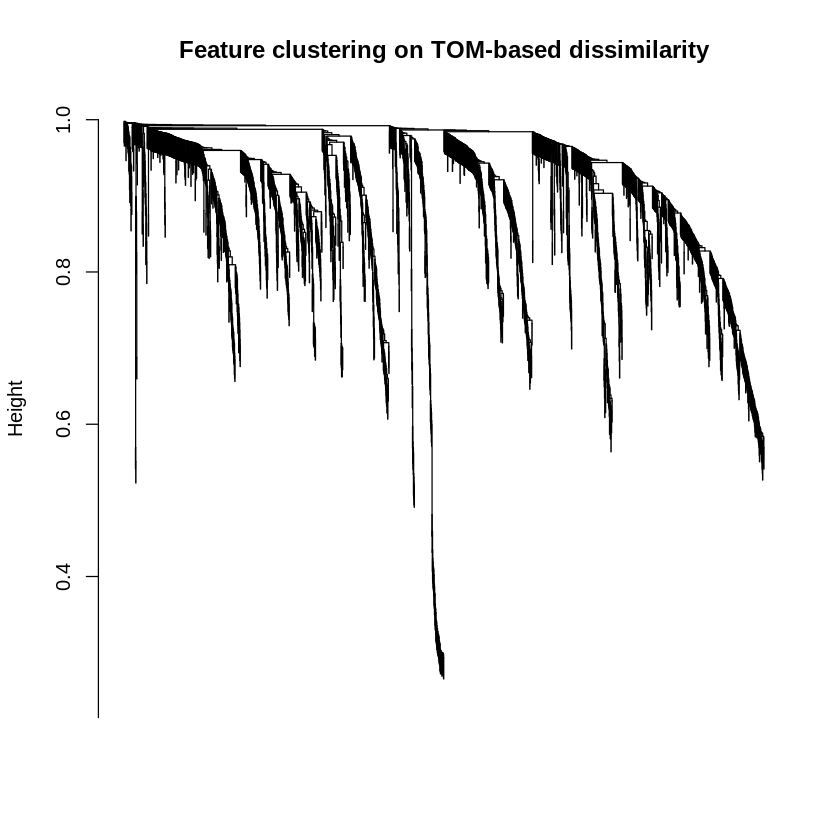

In [38]:
# Call the hierarchical clustering function
metabTree <- fastcluster::hclust(as.dist(dissTOM), method = "average")
# Plot the resulting clustering tree (dendrogram)
plot(metabTree, xlab="", sub="", main = "Feature clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)
# Height is 1-TO

### Finding modules
 In the clustering tree (dendrogram), each leaf, that is a short vertical line, corresponds to a feature. Branches of the dendrogram group together densely interconnected, highly correlated features. Module identification consists of cutting the branches off the dendrogram. There are several methods for branch cutting. We use the Dynamic Tree Cut from the package dynamicTreeCut. It is possible to verify the stability of the modules within the WGCNA package (not reported in this notebook).

In [39]:
minModuleSize <- 20 # default is 20
# Module identification using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = metabTree, pamStage=FALSE,
                            minClusterSize = minModuleSize, 
                            cutHeight = 0.99, ## Consider high maximum joining heights for dendrogram 
                            deepSplit = 2, distM = dissTOM, method = 'hybrid')
# deepSplit allows us to cut more, obtaining large modules if needed. Default is 2 (range 0-4)
# Features in each module (0 corresponds to no correlation)
table(dynamicMods)

 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1319  182  173  162  120   77   76   67   56   45   45   44   43   42   40   36 
  16   17   18   19   20   21 
  31   28   27   26   22   20 

In [40]:
# We now plot the module assignment under the gene dendrogram.
# Convert numeric lables into colors:
dynamicColors <- labels2colors(dynamicMods)

# Number of features in each module (grey is no correlation and usually contains the largest number of features)
table(dynamicColors)
# total number of modules
length(unique(dynamicColors))

dynamicColors
       black         blue        brown         cyan      darkred        green 
          67          173          162           40           20           77 
 greenyellow         grey       grey60    lightcyan   lightgreen  lightyellow 
          44         1319           28           31           27           26 
     magenta midnightblue         pink       purple          red    royalblue 
          45           36           56           45           76           22 
      salmon          tan    turquoise       yellow 
          42           43          182          120 

[1] 22

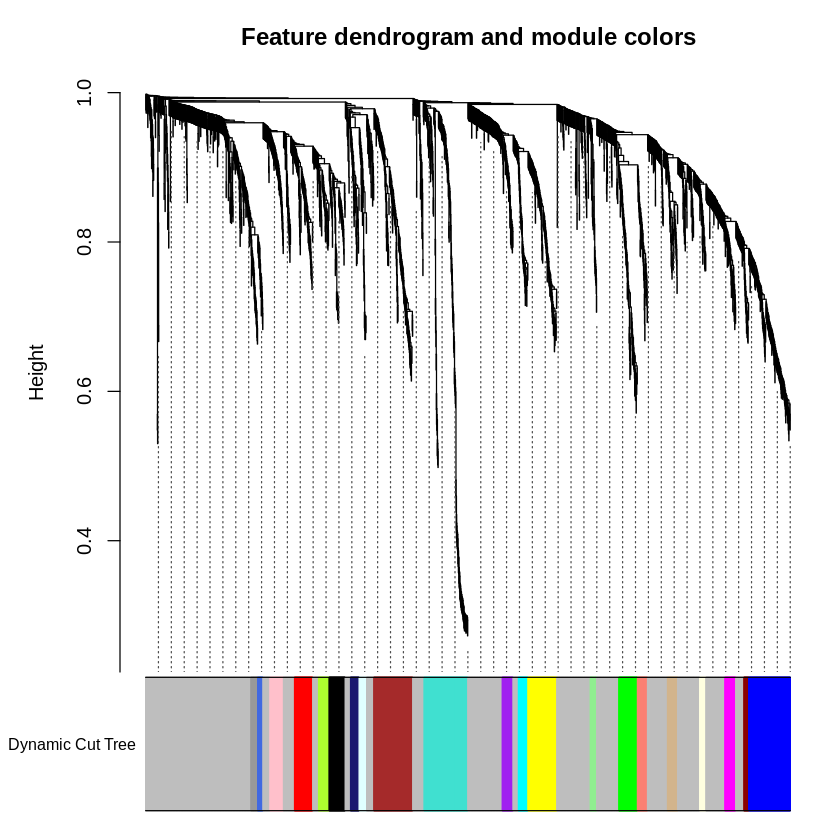

In [41]:
# Plot the dendrogram and colors underneath.
plotDendroAndColors(metabTree, dynamicColors, "Dynamic Cut Tree",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Feature dendrogram and module colors")

### Merging modules whose metabolite profiles are very similar
The Dynamic Tree Cut may identify modules whose intesity profiles are very similar. We merge such modules since their features are highly correlated. To quantify correlation similarity of entire modules, we calculate their eigengenes and cluster them on their correlation. The module eigengene is defined as the first principal component of a given module. It can be considered a representative of the feature intensity profiles in a module.

In [42]:
# Calculate eigengenes
MEList <- moduleEigengenes(ft_mad, colors = dynamicColors)
MEs <- MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss <- 1-cor(MEs) # if you do not have NAs in your data
# MEDiss = 1-cor(MEs, use = 'pairwise.complete.obs') # if you have NAs in your data

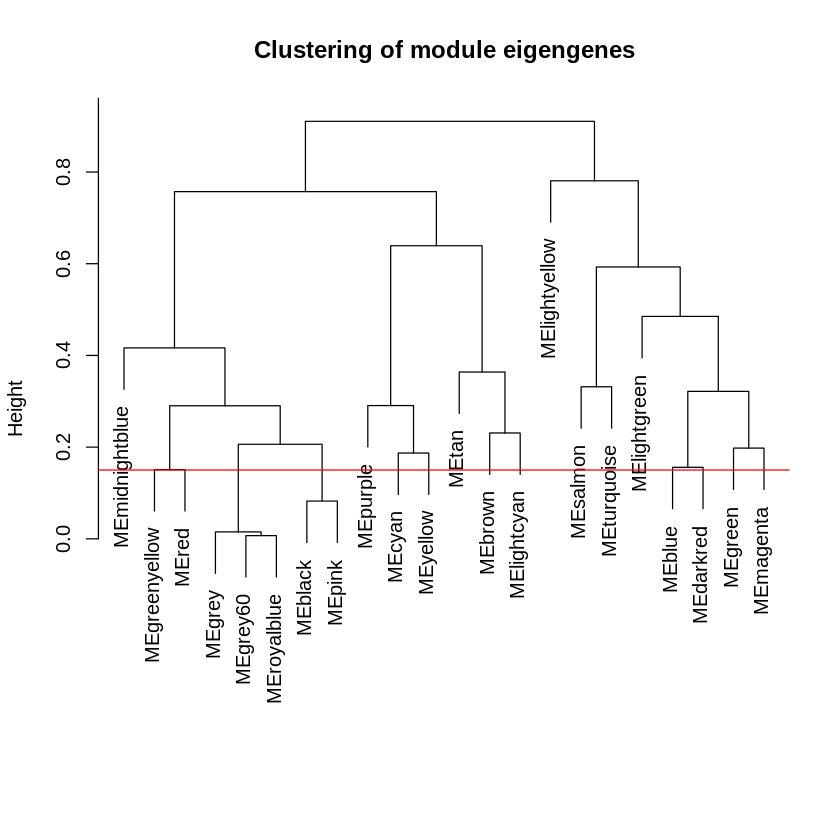

In [43]:
# Cluster module eigengenes
METree <- hclust(as.dist(MEDiss), method = "average")

# Plot the result
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")
# Based on previous literature, I decided for r>0.85 (corresponding to height = 0.15 in the dendrogram)
MEDissThres <- 0.15
# Plot the cut line on top of the dendrogram
abline(h=MEDissThres, col = "red")

 mergeCloseModules: Merging modules whose distance is less than 0.15
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 22 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 20 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 20 module eigengenes in given set.


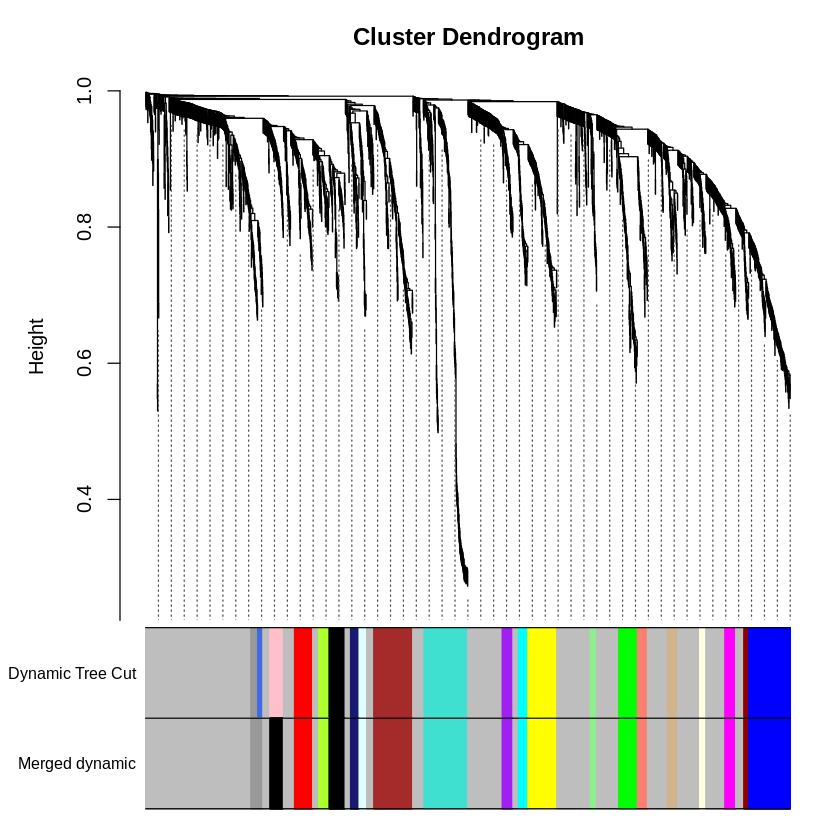

In [44]:
# Call an automatic merging function
merge <- mergeCloseModules(ft_mad, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors <- merge$colors
# Eigengenes of the new merged modules:
mergedMEs <- merge$newMEs

# To see what the merging step did to our module colors, we plot the gene dendrogram again, with the original and merged 
# module colors underneath.
plotDendroAndColors(metabTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [45]:
table(mergedColors)
# number of modules after merging
length(unique(mergedColors))

mergedColors
       black         blue        brown         cyan      darkred        green 
         123          173          162           40           20           77 
 greenyellow         grey       grey60    lightcyan   lightgreen  lightyellow 
          44         1319           50           31           27           26 
     magenta midnightblue       purple          red       salmon          tan 
          45           36           45           76           42           43 
   turquoise       yellow 
         182          120 

[1] 20

### Correlate modules to metadata

In [46]:
table(md$ATTRIBUTE_species)
table(md$specie)
table(md$ATTRIBUTE_SampleType)
table(md$sample_class)


B.subtilis     E.coli 
        40         40 


 0  1 
40 40 


   With_Treatment Without_Treatment 
               60                20 


 0  1 
20 60 

In [47]:
# columns of interest
names(md)[8]
names(md)[9]
names(md)[6]

[1] "specie"

[1] "sample_class"

[1] "ATTRIBUTE_mins"

In [48]:
# calculate correlations for binary class (specie)
metTraitCorrSpecie <- as.data.frame(cor(ft_mad, md$specie, use = "p"))

# calculate p-value
MSPvalueSpecie <- as.data.frame(corPvalueStudent(as.matrix(metTraitCorrSpecie), nSamples = length(rownames(ft_mad))))
names(metTraitCorrSpecie) <- paste("MS.", names(md)[8], sep="")
names(MSPvalueSpecie) <- paste("p.MS.", names(md)[8], sep="")

identical(rownames(metTraitCorrSpecie),rownames(MSPvalueSpecie)) # TRUE, because the position of the rows is not altered during 
# the entire analysis

[1] TRUE

In [49]:
# calculate correlations for binary class (sample_class)
metTraitCorrSample <- as.data.frame(cor(ft_mad, md$sample_class, use = "p"))

# calculate p-value
MSPvalueSample <- as.data.frame(corPvalueStudent(as.matrix(metTraitCorrSample), nSamples = length(rownames(ft_mad))))
names(metTraitCorrSample) <- paste("MS.", names(md)[9], sep="")
names(MSPvalueSample) <- paste("p.MS.", names(md)[9], sep="")

identical(rownames(metTraitCorrSample),rownames(MSPvalueSample)) # TRUE, because the position of the rows is not altered during 
# the entire analysis

[1] TRUE

In [50]:
# calculate correlations for minutes
metTraitCorrMins <- as.data.frame(cor(ft_mad, md$ATTRIBUTE_mins, use = "p"))

# calculate p-value
MSPvalueMins <- as.data.frame(corPvalueStudent(as.matrix(metTraitCorrMins), nSamples = length(rownames(ft_mad))))
names(metTraitCorrMins) <- paste("MS.", names(md)[6], sep="")
names(MSPvalueMins) <- paste("p.MS.", names(md)[6], sep="")

identical(rownames(metTraitCorrMins),rownames(MSPvalueMins)) # TRUE, because the position of the rows is not altered during 
# the entire analysis

[1] TRUE

#### Convert numeric labels into colors
In the following we want to convert the correlations into colors and then add these colors to the metabTree. If signed is TRUE, the default setting is to use a palette that starts with blue for the most negative values, continues with white for values around zero and turns red for positive values.

In [51]:
signed <- TRUE
MScolorsSpecie <- numbers2colors(
  as.matrix(cbind(metTraitCorrSpecie$MS.specie)),
  signed,
  centered = signed,
  lim = NULL,
  colors = if (signed) blueWhiteRed(100) else blueWhiteRed(100)[50:100],
  naColor = "grey")

In [52]:
MScolorsSample <- numbers2colors(
  as.matrix(cbind(metTraitCorrSample$MS.sample_class)),
  signed,
  centered = signed,
  lim = NULL,
  colors = if (signed) blueWhiteRed(100) else blueWhiteRed(100)[50:100],
  naColor = "grey")

In [53]:
MScolorsMins <- numbers2colors(
  as.matrix(cbind(metTraitCorrMins$MS.ATTRIBUTE_mins)),
  signed,
  centered = signed,
  lim = NULL,
  colors = if (signed) blueWhiteRed(100) else blueWhiteRed(100)[50:100],
  naColor = "grey")

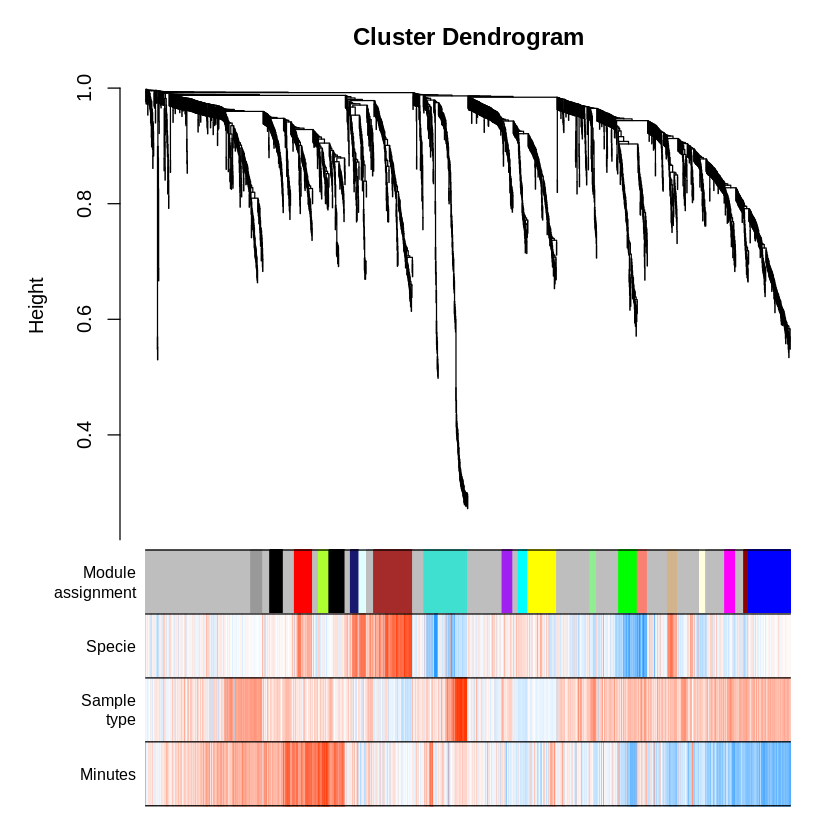

In [54]:
# Plot
plotDendroAndColors(metabTree, cbind(mergedColors, MScolorsSpecie, MScolorsSample, MScolorsMins), 
                    c('Module\n assignment','Specie','Sample\ntype','Minutes'),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = FALSE, guideHang = 0.05)

### Focus on interesting modules
In the following code we will plot an heatmap of the most interesting modules based on the previous analysis. We will also plot a barplot of the 'eigengene' intesities for those modules.

[1] "#67001F" "#B2182B" "#D6604D" "#F4A582" "#FDDBC7" "#D1E5F0" "#92C5DE"
 [8] "#4393C3" "#2166AC" "#053061"

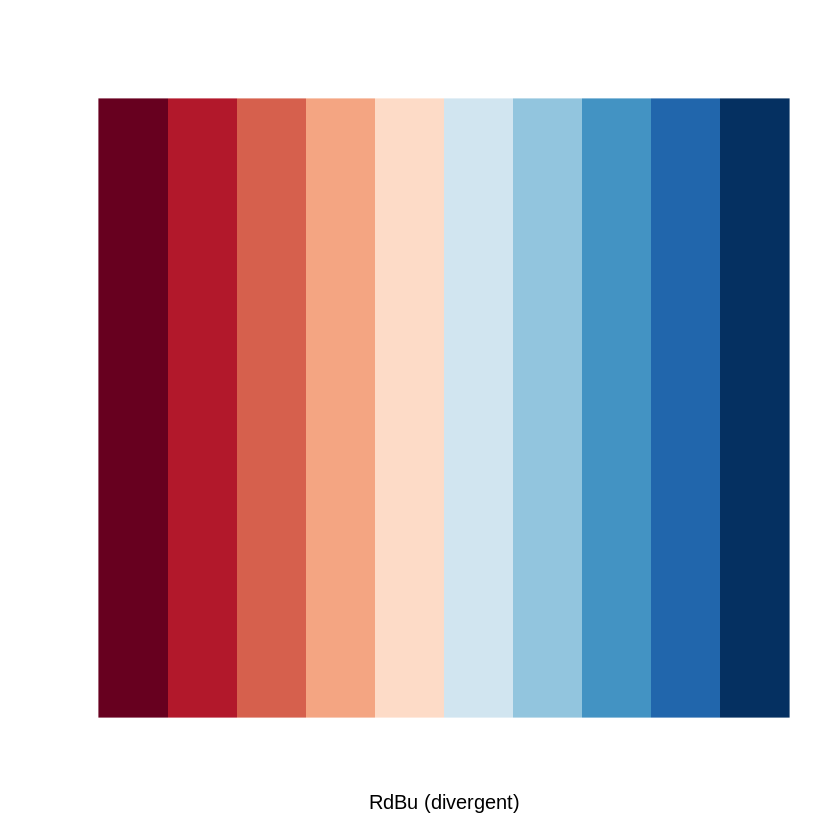

In [55]:
# select some colors to use for showing the time points
display.brewer.pal(n = 10, name = 'RdBu')
# Hexadecimal color specification 
brewer.pal(n = 10, name = "RdBu")

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



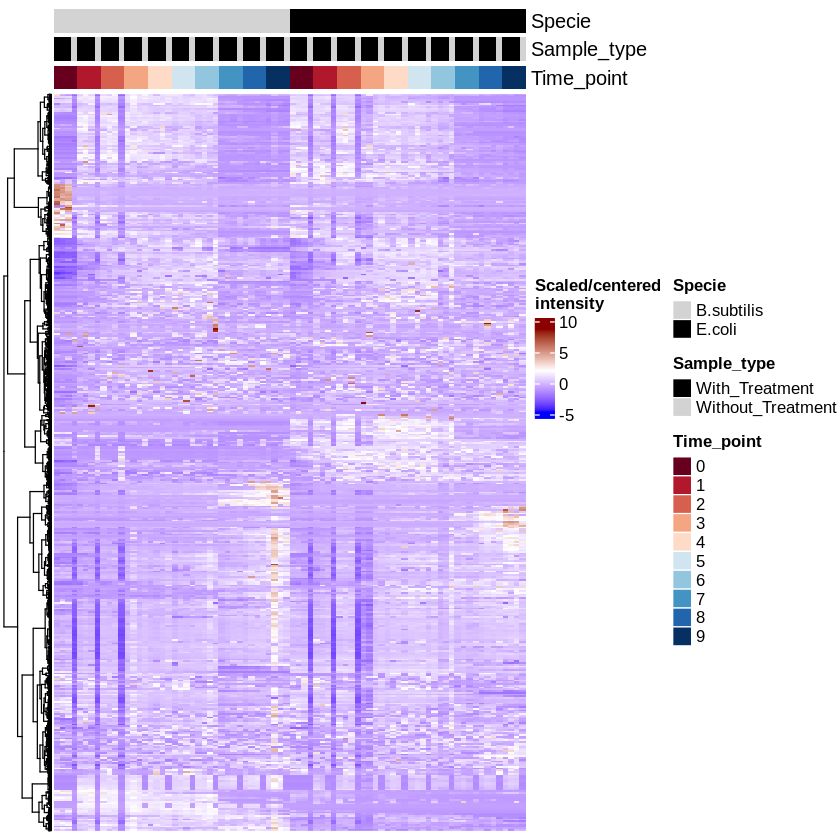

In [56]:
# Heatmap for all metabolites and samples

# set top annotation
ann <- data.frame(md$ATTRIBUTE_species, md$ATTRIBUTE_SampleType, md$ATTRIBUTE_timepoint)
colnames(ann) <- c('Specie', 'Sample_type', 'Time_point')
colours <- list('Specie' = c('B.subtilis' = 'lightgrey', 'E.coli' = 'black'), 'Sample_type'= c('Without_Treatment'= 'lightgrey','With_Treatment' = 'black'),
  'Time_point' = c('0' = '#67001F', '1' = '#B2182B', '2' = '#D6604D', '3' = '#F4A582', '4' = '#FDDBC7', '5' = '#D1E5F0', '6' = '#92C5DE', '7' = '#4393C3', 
  '8' = '#2166AC', '9' = '#053061'))
colAnn <- HeatmapAnnotation(df = ann,
  which = 'col',
  col = colours,
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'))

# set heatmap
hmap <- Heatmap(
  t(ft_mad),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_method_rows = "ward.D2",
  clustering_method_columns = "ward.D2",
  width = unit(100, "mm"),
  top_annotation = colAnn)

# draw heatmap
draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



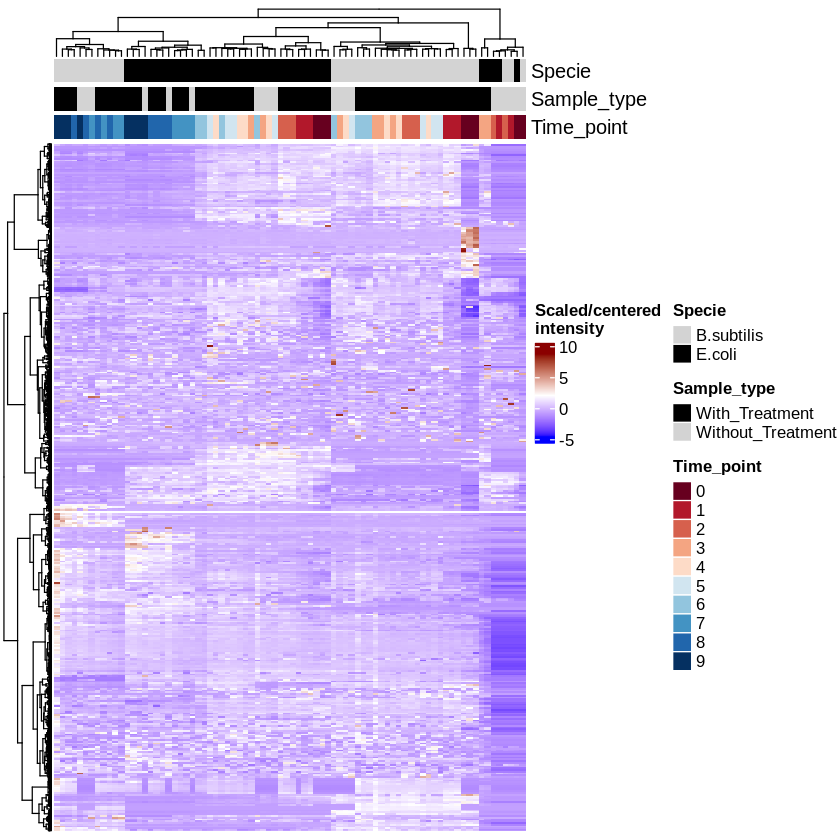

In [57]:
# you can also cluster the columns (samples)
# Heatmap for all metabolites and samples

# set heatmap
hmap <- Heatmap(
  t(ft_mad),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  show_column_dend = TRUE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_method_rows = "ward.D2",
  clustering_method_columns = "ward.D2",
  width = unit(100, "mm"),
  top_annotation = colAnn)

# draw heatmap
draw(hmap, heatmap_legend_side="right", annotation_legend_side="right")

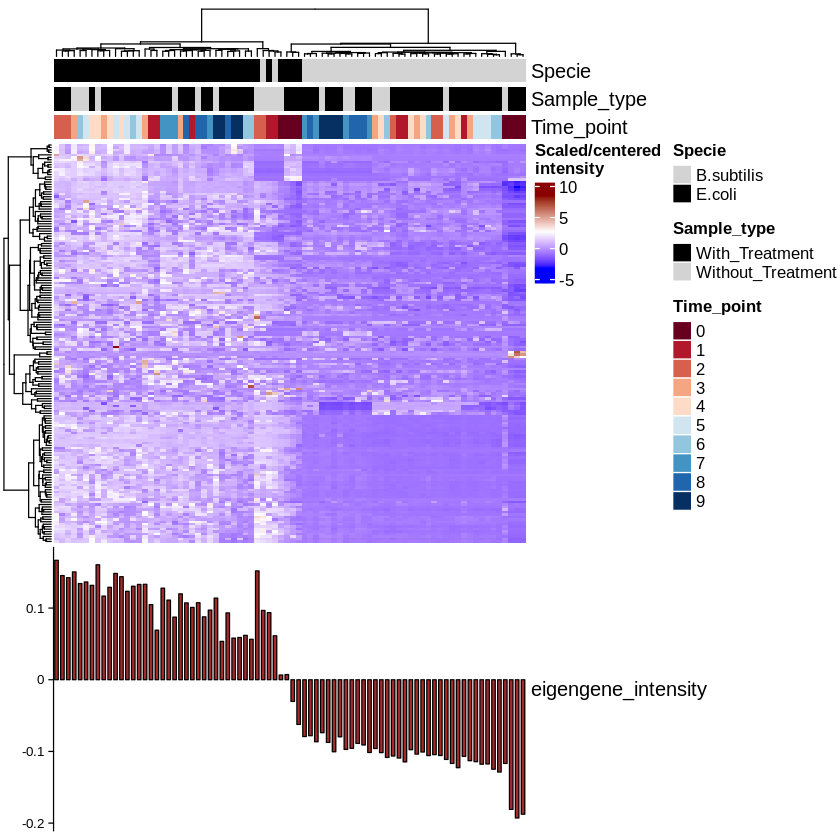

In [58]:
# Heatmaps for selected modules

# which module we want to focus on and plot the heatmap and barplot
which_module <- "brown"

ME_2 <- mergedMEs[, paste("ME",which_module, sep="")]

# bottom annotation/barplot
ha_2 <- HeatmapAnnotation(eigengene_intensity = anno_barplot(ME_2, gp = gpar(fill = which_module), border = FALSE, height = unit(6, "cm")))

# set heatmap
hmap_2 <- Heatmap(
  t(ft_mad[,mergedColors==which_module]),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  show_column_dend = TRUE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_method_rows = "ward.D2",
  clustering_method_columns = "ward.D2",
  width = unit(100, "mm"),
  top_annotation = colAnn,
  bottom_annotation = ha_2)

# draw heatmap
draw(hmap_2, heatmap_legend_side="right", annotation_legend_side="right")

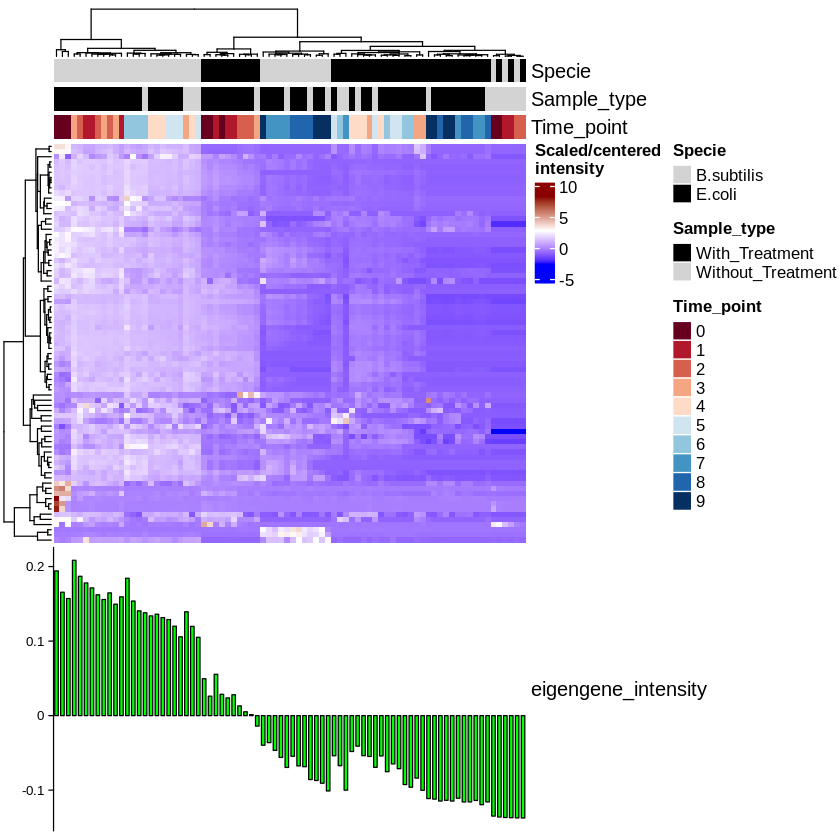

In [59]:
# Heatmaps for another module

# which module we want to focus on and plot the heatmap and barplot
which_module <- "green"

ME_3 <- mergedMEs[, paste("ME",which_module, sep="")]

# bottom annotation/barplot
ha_3 <- HeatmapAnnotation(eigengene_intensity = anno_barplot(ME_3, gp = gpar(fill = which_module), border = FALSE, height = unit(6, "cm")))

# set heatmap
hmap_3 <- Heatmap(
  t(ft_mad[,mergedColors==which_module]),
  heatmap_legend_param = list(title = "Scaled/centered\nintensity"), 
  col = c("blue","white","darkred"),
  show_row_names = FALSE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  show_column_dend = TRUE,
  show_row_dend = TRUE,
  row_dend_reorder = TRUE,
  column_dend_reorder = TRUE,
  clustering_method_rows = "ward.D2",
  clustering_method_columns = "ward.D2",
  width = unit(100, "mm"),
  top_annotation = colAnn,
  bottom_annotation = ha_3)

# draw heatmap
draw(hmap_3, heatmap_legend_side="right", annotation_legend_side="right")

### Show highly correlated features with metadata
In the following section, we will show a table reporting the most significant and correlated features with the metadata information (i.e. Species and Minutes).

In [60]:
# bind correlations and p-values for Specie
PvalueCorr_specie <- cbind(metTraitCorrSpecie,MSPvalueSpecie)
# bind colors for each metabolite
PvalueCorr_specie_colors <- cbind(mergedColors,PvalueCorr_specie)

# remove grey color (no correlation of metabolites)
PvalueCorr_specie_colors <- PvalueCorr_specie_colors[PvalueCorr_specie_colors$mergedColors!='grey',]
names(PvalueCorr_specie_colors) <- c('module','correlation','pvalue')

In [61]:
# keep pvalues < 0.05 and corr > 0.3 as minimum filters
sign_vars_pos <- PvalueCorr_specie_colors %>%
  filter(pvalue < 0.05 & correlation > 0.3)
sign_vars_pos <- sign_vars_pos[order(sign_vars_pos$pvalue, decreasing = F),]

In [62]:
# number of significant features based on the applied filter
dim(sign_vars_pos)[1]

[1] 327

In [63]:
# top 20 features
head(sign_vars_pos, n = 20)

,module,correlation,pvalue
,<chr>,<dbl>,<dbl>
8999_420.885_6.438,brown,0.9235054,3.383554e-34
9002_488.872_6.443,brown,0.9075472,4.026135e-31
8987_362.926_6.429,brown,0.9001256,7.082162e-30
8977_430.914_6.424,brown,0.8862146,8.728176e-28
9000_422.882_6.44,brown,0.8846950,1.421318e-27
9004_294.939_6.438,brown,0.8718429,6.805031e-26
8428_294.939_6.26,brown,0.8691316,1.459444e-25
8631_294.939_6.302,brown,0.8671662,2.510689e-25
8582_430.914_6.275,brown,0.8663458,3.140792e-25


In [64]:
# modules containing significant features (showing the number of significant features in each module)
table(sign_vars_pos$module)


       black         blue        brown         cyan  greenyellow    lightcyan 
           1            3          151            2            1           29 
  lightgreen midnightblue       purple          red          tan    turquoise 
           1           29            6           43           39            4 
      yellow 
          18 

From here, we can combine the previous results and visualizations with the annotated features obtained elsewhere.

In [65]:
# for reproducibility
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] ComplexHeatmap_2.12.0 RColorBrewer_1.1-3    dplyr_1.0.9          
[4] doParallel_1.0.17     iterators_1.0.14      foreach_1.5.2        
[7] WGCNA_1.71            fastcluster_1.2.3     dynamicTreeCut_1.63-1

loaded via a namespace (and not att